In [1]:
import import_ipynb
import SimpleITK as sitk
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage import measure, segmentation
import scipy.ndimage as ndimage
from lung_image import Segmentation
from skimage.filters import threshold_multiotsu
from skimage.segmentation import clear_border
from matplotlib.patches import Circle
import imutils
from scipy.spatial import ConvexHull
from skimage import io, morphology
from math import pi

importing Jupyter notebook from lung_image.ipynb


In [2]:
candidatePatches = {"name": [], "image": []}

In [3]:
def FilterImages(candidates, cleanedUpList):    
    Nodules = candidates[candidates['class'] == 1]
    filteredNodules = Nodules[Nodules['seriesuid'].isin(cleanedUpList)]
    return filteredNodules

In [4]:
def getMHDpaths(path):
    if(path.find('mhd') >= 0):
        return True;

In [5]:
def cleaningUpList(path):
    data = path.split(".")
    data.pop()
    filteredPath = ".".join(data)
    return filteredPath;

In [6]:
def ReadCandidateImages(DIR, imageList, candidateNodules):
    for path in imageList:
        Coords = candidateNodules[candidateNodules['seriesuid']==path][['coordX', 'coordY', 'coordZ']].values
        numCandidates = candidateNodules[candidateNodules['seriesuid']==path].shape[0]
        for i in range(numCandidates):
            itkimage = sitk.ReadImage(DIR+path+'.mhd')

            originMatrix = np.tile(itkimage.GetOrigin(), (numCandidates,1))  # Real world origin for this image (0,0)

            candidatesPixels = (np.round(np.absolute(Coords - originMatrix) / itkimage.GetSpacing())).astype(int)

            images = sitk.GetArrayFromImage(itkimage) # Read the image volume
            
            candidateVoxel = candidatesPixels[i,:]
            xpos = int(candidateVoxel[0])
            ypos = int(candidateVoxel[1])
            zpos = int(candidateVoxel[2])

            # Need to handle the candidates where the window would extend beyond the image boundaries
            windowSize = 512
            x_lower = np.max([0, xpos - windowSize])  # Return 0 if position off image
            x_upper = np.min([xpos + windowSize, itkimage.GetWidth()]) # Return  maxWidth if position off image

            y_lower = np.max([0, ypos - windowSize])  # Return 0 if position off image
            y_upper = np.min([ypos + windowSize, itkimage.GetHeight()]) # Return  maxHeight if position off image

            # SimpleITK is x,y,z. Numpy is z, y, x.
            imgPatch = images[zpos, y_lower:y_upper, x_lower:x_upper]

            candidatePatches["name"].append(path)
            candidatePatches["image"].append(imgPatch)  # Append the candidate image patches to a python list
    return candidatePatches

In [7]:
DIR = "Dataset/"
    
candidates = pd.read_csv("candidates_V2.csv")

root = os.path.join(os.getcwd(),DIR)
paths = os.listdir(root)
mhdImages = list(filter(getMHDpaths, paths))
cleanedUpList = list(map(cleaningUpList, mhdImages))

filteredNodules = FilterImages(candidates, cleanedUpList)
candidatePatches = ReadCandidateImages(DIR, cleanedUpList, filteredNodules)
# index 1300 for lung window and 1 index for mediastinal window

In [8]:
from skimage.morphology import disk
def generate_marker(image):
    
    marker_internal_labels = measure.label(image)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    external_a = ndimage.binary_dilation(marker_internal, iterations=11)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    
    marker_external = external_b ^ external_a
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

In [9]:
import skimage
def separate_lungs(image):
    marker_internal, marker_external, marker_watershed = generate_marker(image)
    
    sobel_filtered_dx = ndimage.sobel(noduleImage, 1)
    sobel_filtered_dy = ndimage.sobel(noduleImage, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)
    outline = ndimage.morphological_gradient(watershed, size=(3, 3))
    outline = outline.astype(bool)
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 5)
    outline += ndimage.black_tophat(outline, structure = blackhat_struct)
    lungfilter = np.bitwise_or(marker_internal, outline)
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5, 5)), iterations = 3)
    lungfilter = ndimage.binary_fill_holes(lungfilter, structure=np.ones((3,3))).astype(int)
    segmented = np.where(lungfilter == 1, noduleImage, -2000*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient

In [10]:
def intensity_seg(ct_numpy, min=-1400, max=-150):
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.0001)

In [11]:
def contour_distance(contour):
    """
    Given a set of points that may describe a contour
     it calculates the distance between the first and the last point
     to infer if the set is closed.
    Args:
        contour: np array of x and y points

    Returns: euclidean distance of first and last point
    """
    dx = contour[0, -1] - contour[-1, -1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

In [12]:
def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

In [22]:
def find_lungs(contours):
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

       # set some constraints for the volume
        if hull.volume > 1000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    # Discard body contour
    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) == 3:
        vol_contours, body_and_lung_contours = (list(t) for t in
                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(0) # body is out!
    elif len(body_and_lung_contours) > 3:
        vol_contours, body_and_lung_contours = (list(t) for t in
                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1) # body is out!
    return body_and_lung_contours # only lungs left !!!

In [15]:
from PIL import Image, ImageDraw
def create_mask_from_polygon(image, contours):
    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary
    return lung_mask.T  # transpose it to be aligned with the image dims

In [16]:
def show_slice(slice):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    plt.figure()
    plt.imshow(slice, cmap="gray")

In [17]:
def euclidean_dist(dx, dy):
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

In [18]:
def denoise_vessels(lung_contour, vessels):
    vessels_coords_x, vessels_coords_y = np.nonzero(vessels)  # get non zero coordinates
    for contour in lung_contour:
        x_points, y_points = contour[:, 0], contour[:, 1]
        for (coord_x, coord_y) in zip(vessels_coords_x, vessels_coords_y):
            for (x, y) in zip(x_points, y_points):
                d = euclidean_dist(x - coord_x, y - coord_y)
                if d <= 0.5:
                    vessels[coord_x, coord_y] = 0
    return vessels

In [19]:
def create_vessel_mask(lung_mask, ct_numpy, denoise):
    vessels = lung_mask * ct_numpy  # isolate lung area
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    if denoise:
        return denoise_vessels(lungs, vessels)
    return vessels

In [20]:
def closing_boundary (image):
    outline = np.zeros((512, 512)).astype(np.int)
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 7)
    outline += ndimage.black_tophat(outline, structure = blackhat_struct)
    lungfilter = np.bitwise_or(lung_mask, outline)
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7, 7)), iterations = 5)
    lungfilter = ndimage.binary_fill_holes(lungfilter, structure=np.ones((5,5))).astype(int)
    lungfilter = ndimage.binary_opening(lungfilter, structure=np.ones((9,9))).astype(int)
    return lungfilter

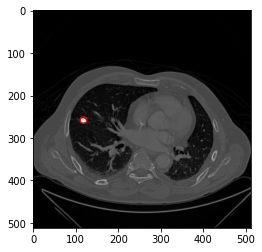

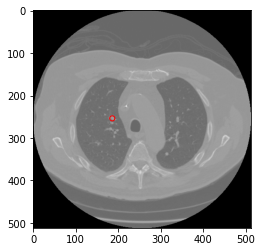

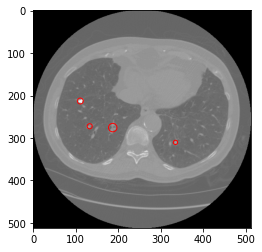

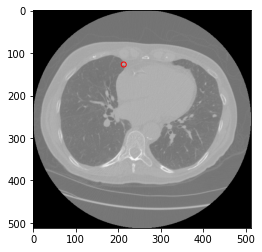

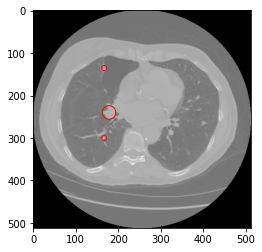

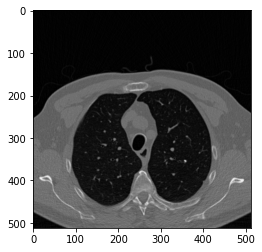

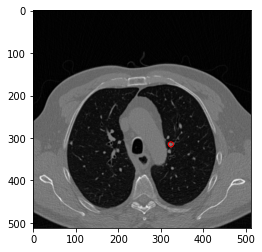

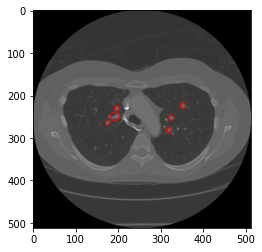

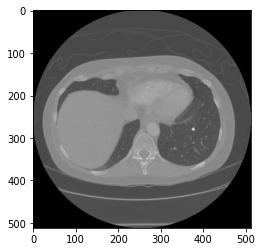

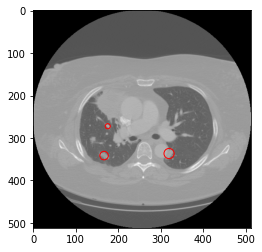

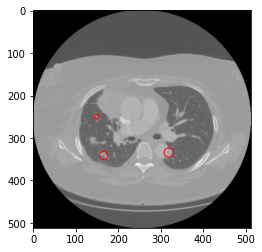

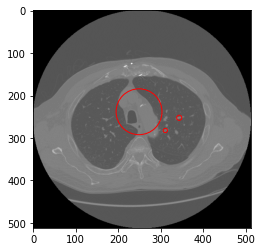

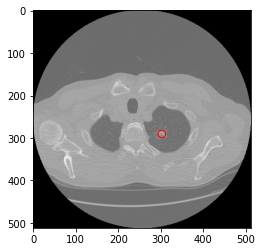

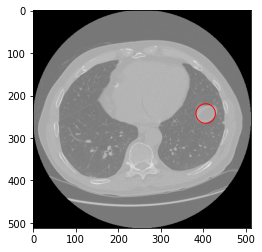

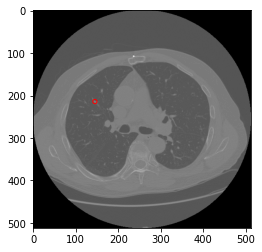

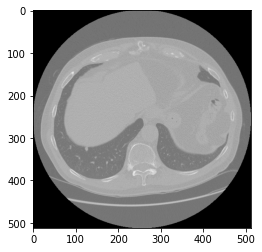

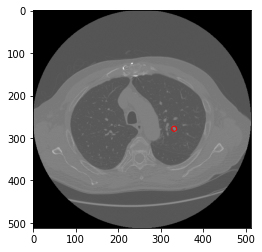

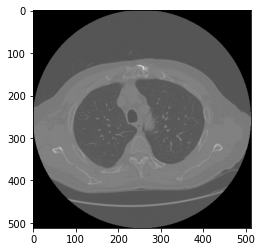

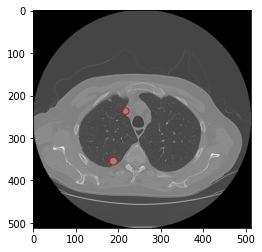

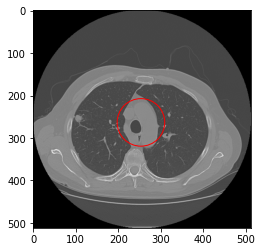

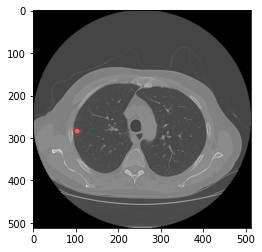

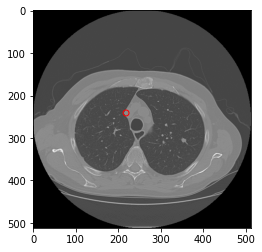

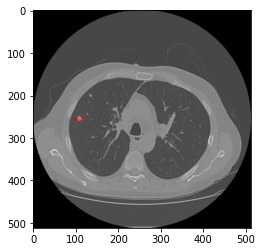

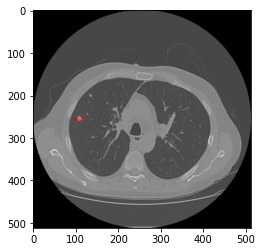

<string>:10: RuntimeWarning: divide by zero encountered in long_scalars


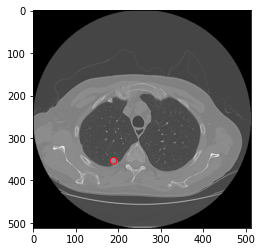

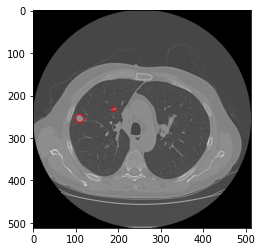

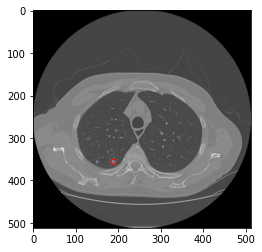

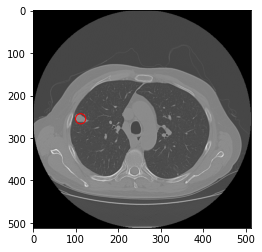

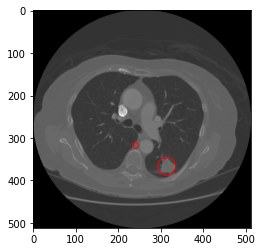

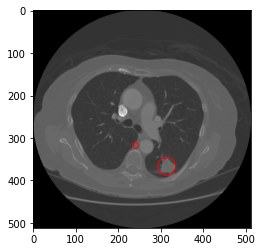

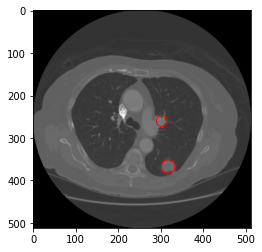

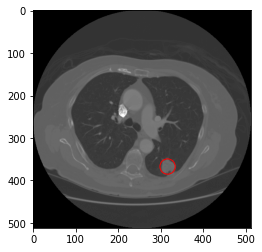

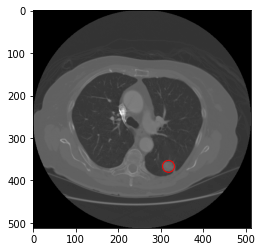

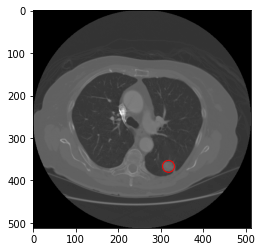

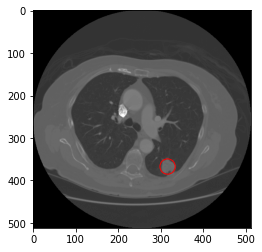

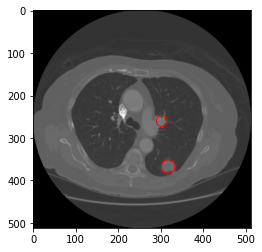

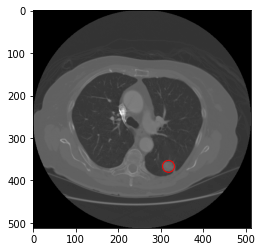

QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 347592424  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0


In [23]:
import cv2
import os
from PIL import Image

#binaryImagePath = "/Volumes/Developer's/Thesis/FilteredImages/slice-{0}-{1}.png"
binaryImagePath = "/Thesis/FilteredImages/slice-{0}-{1}.png"
#segmentedImagePath = "/Thesis/SegmentedImages/slice-{0}-{1}.jpg"
segmentedImagePath = "/Users/apple/Documents/Thesis/SegmentedImages/slice-{0}-{1}.jpg"

for index, noduleImage in enumerate(candidatePatches['image']):
    #Smoothing image
    name = candidatePatches['name'][index]
    lungImage = noduleImage.copy()
    rows, cols = lungImage.shape
    norm = np.zeros((rows, cols))
    normalized_image = cv2.normalize(lungImage, norm, 0, 255, cv2.NORM_MINMAX)
    result = Segmentation(normalized_image, "CT-scan")  
    cv2.imwrite(os.path.join(binaryImagePath).format(index, name), result)
    segmented, lungfilter, outline, watershed, sobel_gradient = separate_lungs(result)
    save_path = os.path.join(segmentedImagePath).format(index, name)
    plt.imsave(save_path, segmented, cmap='gray')
    contours = intensity_seg(noduleImage)
    lungs = find_lungs(contours)
    lung_mask = create_mask_from_polygon(noduleImage, lungs)
    lungfilter = closing_boundary(lung_mask)
    vessels_only = create_vessel_mask(lungfilter, noduleImage, False)
    filtered_image = morphology.remove_small_objects(vessels_only.astype(np.bool), min_size=45)
    labels = measure.label(filtered_image)
    props = measure.regionprops(labels)
    fig, ax = plt.subplots()
    max_area = max(prop.area for prop in props)
    blobs = [p.coords for p in props]
    patches = []
    for prop in props:
        y, x = prop.centroid
        diameter = np.mean([prop.major_axis_length, prop.minor_axis_length])
        d = prop.major_axis_length
        pxTomm = 0.26458333 * diameter
        radius = int(diameter//2)
        total_area = int(pi * radius**2)
        white_percent = (prop.area / total_area) * 100
        if(white_percent >= 75): 
            if(pxTomm >= 3 and pxTomm <= 30):
                circle = Circle((x, y), radius, edgecolor='r', facecolor='none')
                ax.add_patch(circle)
    ax.imshow(lungImage, cmap="gray")
    plt.show()